In [7]:
import torch
import torch.nn as nn

Conv2d: 改变深度
MaxPool2d: 改变长宽

In [8]:
class AlexNet( nn.Module ):
    def __init__( self, num_classes, init_weights ):
        super( AlexNet, self ).__init__()
        self.method = nn.Sequential(
            nn.Conv2d( 3, 48, kernel_size = 11, stride = 4, padding =2 ),           
            # in: 3, 224, 224   (224-11+2)/4 + 1 = (为了保证是整数所以选择性删去最后一行) out: 48, 55, 55
            nn.ReLU( inplace=True ),
            nn.MaxPool2d( kernel_size = 3, stride = 2 ),            # (55-3)/2 + 1 = 27     out: 48, 27, 27
            
            nn.Conv2d( 48, 128, kernel_size = 5, padding = 2 ),     # out: 128, 27, 27
            nn.ReLU( inplace=True ),
            nn.MaxPool2d( kernel_size = 3, stride = 2 ),            # (27-5+2)/2 + 1 = 13   out: 128, 13, 13
            
            nn.Conv2d( 128, 192, kernel_size = 3, padding = 1 ),    # out: 192, 13, 13
            nn.ReLU( inplace=True ),
            
            nn.Conv2d( 192, 192, kernel_size = 3, padding = 1 ),    # out: 192, 13, 13
            nn.ReLU( inplace=True ),
            
            nn.Conv2d( 192, 128, kernel_size = 3, padding = 1 ),    # out: 128, 13, 13
            nn.ReLU( inplace=True ),
            
            nn.MaxPool2d( kernel_size = 3, stride = 2 )             # (13-3)/2 +1 = 6       out: 128, 6, 6
        )
        self.classifier = nn.Sequential(
            nn.Dropout( p = 0.5 ),              # 以0.5的概率随机失活节点
            nn.Linear( 128 * 6 * 6, 2048 ),     # 规定接下来的全连接层有2048个节点
            nn.ReLU( inplace=True ),
            
            nn.Dropout( p = 0.5 ),              # 全连接层连接之前进行随机失活操作
            nn.Linear( 2048, 2048 ),
            nn.ReLU( inplace=True ),
            
            nn.Linear( 2048, num_classes ),
        )
        if init_weights:
            self._initialize_weights()
            
    def forward( self, x ):
        x = self.method( x )
        x = torch.flatten( x, start_dim = 1 )   # 深度、高度、宽度展平，不改变batch
        return self.classifier( x )
        
        
        
    def _initialize_weights( self ):            # 初始化权重的方法
        for m in self.modules():
            if isinstance( m, nn.Conv2d ):      # 如果m是卷积层的话，初始化它的权重和偏值
                nn.init.kaiming_normal_( m.weight, mode='fan_out' )
                if m.bias is not None:
                    nn.init.constant_( m.bias, 0 )
            elif isinstance( m, nn.Linear ):
                nn.init.normal_( m.weight, 0, 0.01 )
                nn.init.constant_( m.bias, 0 )
            

导入数据集

- ImageFolder函数假设所有的文件按文件夹保存，每个文件夹下存储同一类别的图片，文件夹名为类别名
- json
    - json.load：表示读取文件，返回python对象
    - json.dump：表示写入文件，文件为json字符串格式，无返回
    - json.dumps：将python中的字典类型转换为字符串类型，返回json字符串 [dict→str]   -> indent参数，格式化输出
    - json.loads：将json字符串转换为字典类型，返回python对象 [str→dict]

In [9]:
from torchvision import transforms, datasets, utils
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import json

device = torch.device( "cuda:0" if torch.cuda.is_available() else"cpu" )

data_pre = {
    "train": transforms.Compose( [ transforms.RandomResizedCrop( 224 ),                     # 随机裁剪为大小为224*224的图片
                                   transforms.RandomHorizontalFlip(),                       # 随机水平方向翻转图片，默认概率0.5
                                   transforms.ToTensor(),                                   # 将图片转为Tensor格式
                                   transforms.Normalize( ( 0.5, 0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ) ]
    ),
    "val": transforms.Compose( [ transforms.Resize( ( 224, 224 ) ),                         # 转成和随机裁剪一样的格式形状
                                 transforms.ToTensor(),
                                 transforms.Normalize( ( 0.5, 0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ) ]
        
    ),
}

train_dataset = datasets.ImageFolder( root = "./data/flower_data/train", transform = data_pre[ 'train' ] )
train_num = len( train_dataset )
test_dataset = datasets.ImageFolder( root = './data/flower_data/val', transform = data_pre[ 'val' ] )
test_num = len( test_dataset )

flower_list = train_dataset.class_to_idx                # {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_dict = dict( ( val, key ) for key, val in flower_list.items() )     # 颠倒键值和值的顺序，方便一一对应
json_s = json.dumps( flower_dict, indent = 4 )
with open( './data/classes.json', 'w' ) as json_f:
    json_f.write( json_s )
    json_f.close()

划分训练集测试集

In [10]:
batch_size = 32

trainloader = torch.utils.data.DataLoader( train_dataset, batch_size = batch_size, shuffle = True )
testloader = torch.utils.data.DataLoader( test_dataset, batch_size = batch_size, shuffle = False )


测试图片

In [11]:
'''
test_data_iter = iter( trainloader )
test_img, test_lbl = test_data_iter.__next__()

def imshow(img):
    img = img / 2 * 0.5                                             # 还原transform对数据的预处理
    npimg = img.numpy()                                             # 转化成numpy格式
    plt.imshow( np.transpose( npimg, ( 1, 2, 0 ) ) )                # 高度，宽度，深度
    plt.show
    
    
print( ' '.join( '%5s' % flower_dict[ test_lbl[j].item() ] for j in range( 4 ) ) )
imshow( utils.make_grid( test_img ) )
'''

"\ntest_data_iter = iter( trainloader )\ntest_img, test_lbl = test_data_iter.__next__()\n\ndef imshow(img):\n    img = img / 2 * 0.5                                             # 还原transform对数据的预处理\n    npimg = img.numpy()                                             # 转化成numpy格式\n    plt.imshow( np.transpose( npimg, ( 1, 2, 0 ) ) )                # 高度，宽度，深度\n    plt.show\n    \n    \nprint( ' '.join( '%5s' % flower_dict[ test_lbl[j].item() ] for j in range( 4 ) ) )\nimshow( utils.make_grid( test_img ) )\n"

In [12]:
net = AlexNet( num_classes = 5, init_weights = True )
net.to( device )
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam( net.parameters(), lr = 0.001 )
t_steps = len( trainloader )

for epoch in range( 10 ):
    net.train()
    running_loss = 0.0                  # 每个epoch的损失
    for step, data in enumerate( trainloader, start = 0 ):
        imgs, labels = data
        rate = ( ( step + 1 ) / t_steps )
        optimizer.zero_grad()
        outputs = net( imgs.to( device ) )
        loss = loss_f( outputs, labels.to( device ) )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        a = '*' * int( rate * 50 )
        b = '.' * int( ( 1 - rate ) * 50 )
        print( '\r train loss: {:^3.0f}%[ {} -> {} ]{:.3f}'.format( int( rate * 100 ),a, b, loss ), end = '' )
    print()    
    
    net.eval()
    r = 0.0                 # 用于记录预测正确的个数
    best_R = 0.0
    with torch.no_grad():
        for data_test in testloader:
            t_img, t_lbl = data_test
            outputs = net( t_img.to( device ) )
            pred_y = torch.max( outputs, dim = 1 )[1]
            r += ( pred_y == t_lbl.to( device ) ).sum().item()
        acc_R = r / test_num
        if acc_R > best_R:
            best_R = acc_R
            torch.save( net.state_dict(), '../path/AlexNet_best.pth' )                # 随时记录最最优训练结果
        print( '[epoch %d] train_loss: %.3f    test_accuracy: %.3f' % ( epoch + 1, running_loss, acc_R ) )
        
        
    print( 'finished' )

 train loss: 100%[ ************************************************** ->  ]1.154
[epoch 1] train_loss: 152.776    test_accuracy: 0.415
finished
 train loss: 100%[ ************************************************** ->  ]1.067
[epoch 2] train_loss: 133.808    test_accuracy: 0.431
finished
 train loss: 100%[ ************************************************** ->  ]0.931
[epoch 3] train_loss: 123.961    test_accuracy: 0.420
finished
 train loss: 100%[ ************************************************** ->  ]0.818
[epoch 4] train_loss: 122.049    test_accuracy: 0.481
finished
 train loss: 100%[ ************************************************** ->  ]1.027
[epoch 5] train_loss: 116.777    test_accuracy: 0.591
finished
 train loss: 100%[ ************************************************** ->  ]1.389
[epoch 6] train_loss: 111.252    test_accuracy: 0.563
finished
 train loss: 100%[ ************************************************** ->  ]1.024
[epoch 7] train_loss: 108.871    test_accuracy: 0.629
f

预测

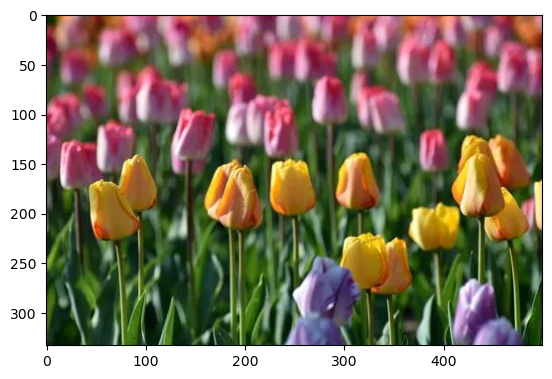

In [13]:
from PIL import Image

img_trans = transforms.Compose(
    [ transforms.Resize( ( 224, 224 ) ),
      transforms.ToTensor(),
      transforms.Normalize( ( 0.5, 0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ) ]
)

img = Image.open( './data/test4.png' ).convert( 'RGB' )
plt.imshow( img )

In [14]:
img = img_trans( img )
# print( img.size() )
img = torch.unsqueeze( img, dim = 0 )               # 补充batch项内容 -> 1
# print( img.size() )

with open( './data/classes.json', 'r' ) as f:
    class_i = json.load( f )
    
    
net.load_state_dict( torch.load( '../path/AlexNet_best.pth' ) )
net.eval()
with torch.no_grad():
    output = torch.squeeze( net( img ) )
    # print( output.size() )
    predict = torch.softmax( output, dim = 0 )
    # print( predict )
    p_class = torch.argmax( predict ).numpy()
    print( class_i[ str( p_class ) ], predict[ p_class ].item() )

tulips 0.5975223779678345
